In [30]:
from hossam import load_data
from pandas import DataFrame, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import statsmodels.api as sm

from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [31]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [49]:
origin = load_data('apple_quality')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head(10)

[data] https://data.hossam.kr/data/kaggle/apple_quality.xlsx
[desc] 이 데이터 세트는 다양한 과일 속성에 대한 정보를 담고 있어 과일의 특성을 파악하는 데 도움이 됩니다. 데이터 세트에는 과일 ID, 크기, 무게, 당도, 아삭함, 과즙량, 숙성도, 산도 및 품질과 같은 세부 정보가 포함되어 있습니다. (출처: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality)

field        description
-----------  ----------------------------------
A_id         각 과일에 대한 고유 식별자
Size         크기
Weight       무게
Sweetness    단맛 정도
Crunchiness  과일의 아삭한 식감을 나타내는 질감
Juiciness    과일의 과즙 함량 정도
Ripeness     과일이 익은 정도
Acidity      과일의 산도 수준
Quality      과일의 전반적인 품질


===== 데이터 크기 확인 =====
데이터셋 크기: (4000, 9)
열 개수: 9
행 개수: 4000

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunc

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good
5,5,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523,bad
6,6,1.331606,1.635956,0.875974,-1.677798,3.106344,-1.847417,2.414171,good
7,7,-1.995462,-0.428958,1.530644,-0.742972,0.158834,0.974438,-1.470125,good
8,8,-3.867632,-3.734514,0.986429,-1.207655,2.292873,4.080921,-4.871905,bad
9,9,-0.727983,-0.442820,-4.092223,0.597513,0.393714,1.620857,2.185608,bad


In [33]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB


1. 연속형은 Size, Weight, Juiciness
범주형은  A_id, Sweetness, Crunchiness, Ripeness, Acidity, Quality 로 확인하였다.
 2. Quality가 중요하다고 생각한다.

In [34]:
타입변경df= origin.astype({'Quality':'category'})
타입변경df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   A_id         4000 non-null   int64   
 1   Size         4000 non-null   float64 
 2   Weight       4000 non-null   float64 
 3   Sweetness    4000 non-null   float64 
 4   Crunchiness  4000 non-null   float64 
 5   Juiciness    4000 non-null   float64 
 6   Ripeness     4000 non-null   float64 
 7   Acidity      4000 non-null   float64 
 8   Quality      4000 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 254.2 KB


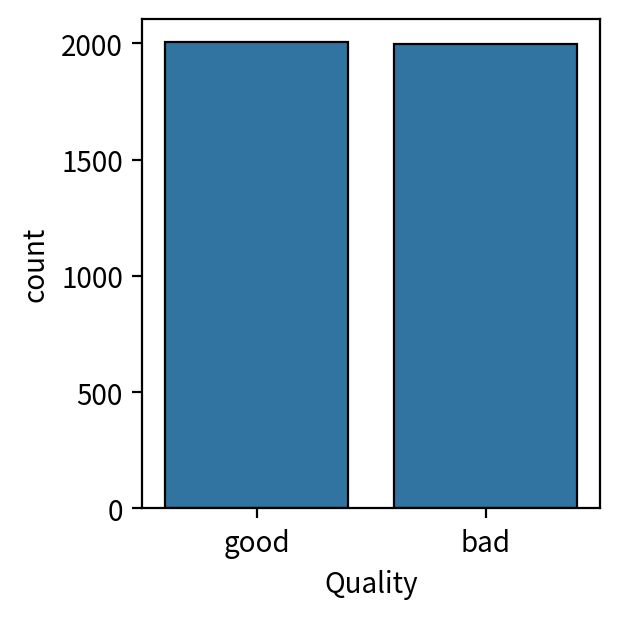

In [35]:
width_px = 640
height_px = 640
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi= my_dpi)

sb.countplot(x=origin['Quality'],  edgecolor="#000000", linewidth=0.8)


plt.tight_layout()
plt.show()
plt.close()

In [36]:
origin['Quality'].value_counts(normalize=True)


Quality
good    0.501
bad     0.499
Name: proportion, dtype: float64

막대그래프 또는 지표로 보았을때  불균형하지 않고 good과 bad가 0.501:0.499로 균형을 이루고 있다.

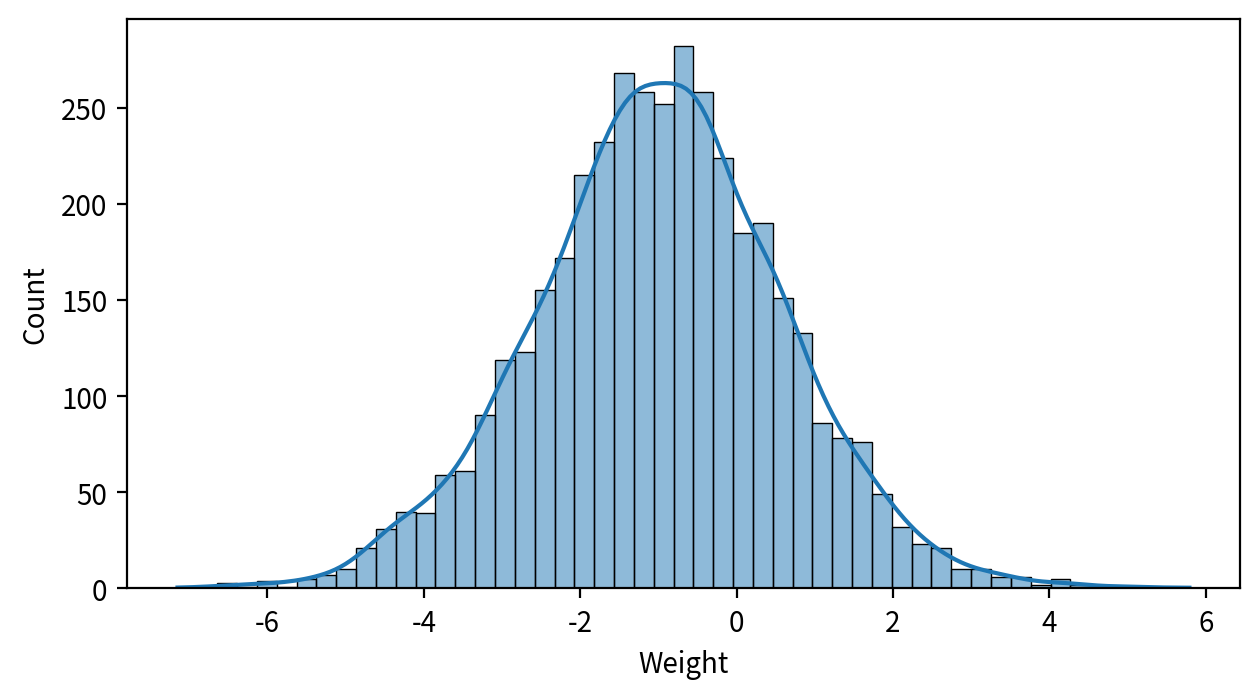

In [48]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.histplot(data=origin, x="Weight", edgecolor="#000000", 
            linewidth=0.5, kde=True)


plt.tight_layout()
plt.show()
plt.close()

In [39]:
origin['Weight'].skew()

np.float64(0.003101570142725525)

In [40]:
origin.skew(numeric_only=True)


A_id           0.000000
Size          -0.002437
Weight         0.003102
Sweetness      0.083850
Crunchiness    0.000230
Juiciness     -0.113421
Ripeness      -0.008764
Acidity        0.055783
dtype: float64

왜도를 구했을 때 절댓값이 2보다 작아